# Задача 1. Hand-crafted graph features

## Задача

- [ ] Найти или сгенерировать набор данных для бинарной классификации графов.
- [ ] Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- [ ] Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- [ ] (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

---



Установим необходимые библиотеки для работы:

In [70]:
!pip install -q datasets

from datasets import load_dataset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

from collections import Counter, defaultdict

В данной работе будем использовать набор данных `MUTAG` — это один из **классических** и **широко используемых** наборов данных в области графовых нейронных сетей и хемоинформатики. Он содержит информацию о 188 молекулах, представленных в виде графов, где узлы соответствуют атомам, а ребра — химическим связям между ними.

Каждая молекула в наборе данных помечена меткой класса, указывающей на ее мутагенность — способность вызывать генетические мутации. Метки принимают два значения: мутагенный или немутагенный. Цель использования этого набора данных — разработка и оценка алгоритмов классификации графов, которые могут предсказывать мутагенность соединений на основе их молекулярной структуры.

In [ ]:
data = load_dataset("graphs-datasets/MUTAG");
data

DatasetDict({
    train: Dataset({
        features: ['edge_index', 'node_feat', 'edge_attr', 'y', 'num_nodes'],
        num_rows: 188
    })
})

Разделим данные на тренировочную и тестовую выборки:

In [86]:
graphs = data['train']

indices = list(range(len(graphs)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=graphs['y'])

train_dataset = graphs.select(train_indices)
test_dataset = graphs.select(test_indices)

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер тестовой выборки: {len(test_dataset)}")

Размер обучающей выборки: 150
Размер тестовой выборки: 38


Реализуем функцию отрисовки графа на основе алгоритма `spring`:

In [61]:
def visualize_graph(graph_data):
    """
    Визуализирует граф на основе предоставленных данных.

    Параметры:
    -----------
    graph_data: dict
        Словарь с информацией о графе, содержащий рёбра ('edge_index'),
        количество узлов ('num_nodes'), признаки узлов ('node_feat') и метку графа ('y').

    Возвращает:
    -----------
    G: networkx.Graph
        Объект графа, построенный с использованием библиотеки NetworkX.
    """
    edge_index = graph_data['edge_index']  # Рёбра графа
    num_nodes = graph_data['num_nodes']    # Количество узлов
    node_labels = [str(int(label[0])) if isinstance(label, list) else str(label) for label in graph_data['node_feat']]

    # Создаем пустой граф
    G = nx.Graph()

    # Добавляем узлы с метками
    for i in range(num_nodes):
        G.add_node(i, label=str(node_labels[i]))

    # Добавляем рёбра
    edges = list(zip(edge_index[0], edge_index[1]))
    G.add_edges_from(edges)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    labels = nx.get_node_attributes(G, 'label')

    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_edges(G, pos, width=1.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=12)

    plt.axis('off')
    plt.title(f'Граф из тренировочного набора данных MUTAG')
    plt.show()

    return G

Визуализируем графы, содержащиеся в обучающем наборе:

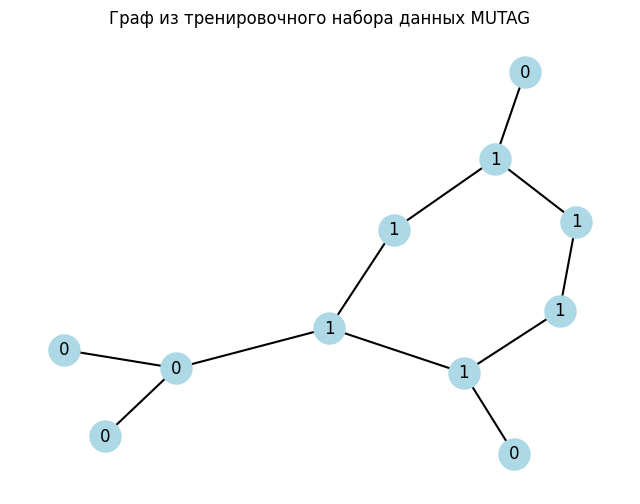

In [ ]:
G = visualize_graph(train_dataset[0])

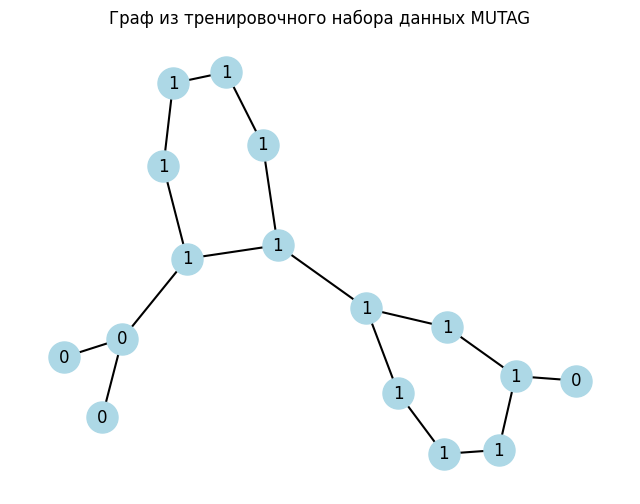

In [ ]:
G = visualize_graph(train_dataset[42])

**Shortest Path Kernel** — ядро, основанное на количестве кратчайших путей разной длины в графах. Этот метод позволяет количественно оценить, насколько два графа схожи по своим структурным характеристикам, и использовать эту информацию для классификации графов. Для этого

1. Для каждого графа G:
   - Вычислим кратчайшие пути между всеми парами узлов.
   - Построим вектор кратчайших путей, где каждый элемент - это количество путей определенной длины.
   
2. Для всех пар графов в тренировочном наборе:
   - Вычислим скалярное произведение векторов кратчайших путей для каждой пары графов.
   - Запишем результаты в матрицу `K_train`.

3. Для всех пар графов (графы `test` и графы `train`):
   - Вычислим скалярное произведение векторов кратчайших путей для каждой пары (`test`, `train`).
   - Запишем результаты в матрицу `K_test`.

In [91]:
def graph_to_shortest_path_vector(G, max_length):
    """
    Преобразует граф в вектор, где каждый элемент соответствует количеству кратчайших путей определенной длины.

    Параметры:
    ----------
    G: networkx.Graph
        Граф, для которого нужно вычислить вектор кратчайших путей.
    max_length: int
        Максимальная длина кратчайшего пути для выравнивания размеров векторов.

    Возвращает:
    -----------
    vector: np.array
        Вектор, в котором количество кратчайших путей каждой длины.
    """
    # Вычисляем все кратчайшие пути между всеми парами узлов
    path_lengths = dict(nx.shortest_path_length(G))

    # Создаем словарь для подсчета кратчайших путей каждой длины
    path_length_counts = {}

    # Заполняем словарь длинами кратчайших путей
    for source in path_lengths:
        for target, length in path_lengths[source].items():
            if source != target:  # исключаем нулевые пути (между одинаковыми узлами)
                if length not in path_length_counts:
                    path_length_counts[length] = 0
                path_length_counts[length] += 1

    # Преобразуем словарь в вектор фиксированной длины max_length
    vector = np.zeros(max_length + 1)

    for length, count in path_length_counts.items():
        if length <= max_length:
            vector[length] = count

    return vector

In [62]:
def kernel_function(vector1, vector2):
    """
    Вычисляетскалярное произведение для двух векторов.

    Параметры:
    ----------
    vector1: np.array
        Вектор для первого графа.
    vector2: np.array
        Вектор для второго графа.

    Возвращает:
    -----------
    scalar_product: float
        Результат скалярного произведения двух векторов.
    """
    return np.dot(vector1, vector2)

In [94]:
def shortest_path_kernel(train_graphs, test_graphs):
    """
    Вычисляет матрицы K_train и K_test на основе кратчайших путей для тренировочных и тестовых графов.

    Параметры:
    ----------
    train_graphs: list of networkx.Graph
        Список графов для тренировочного набора.
    test_graphs: list of networkx.Graph
        Список графов для тестового набора.

    Возвращает:
    -----------
    K_train: np.array
        Матрица ядер для сравнения графов тренировочного набора.
    K_test: np.array
        Матрица ядер для сравнения графов тестового набора с тренировочными.
    """
    # Определяем максимальную длину кратчайшего пути среди всех графов
    max_train_length = max([max([max(lengths.values()) for lengths in dict(nx.shortest_path_length(G)).values()]) for G in train_graphs])
    max_test_length = max([max([max(lengths.values()) for lengths in dict(nx.shortest_path_length(G)).values()]) for G in test_graphs])

    max_length = max(max_train_length, max_test_length)  # Общая максимальная длина

    # Преобразуем графы в векторы кратчайших путей
    train_vectors = [graph_to_shortest_path_vector(G, max_length) for G in train_graphs]
    test_vectors = [graph_to_shortest_path_vector(G, max_length) for G in test_graphs]

    # Инициализируем матрицу K_train
    n_train = len(train_vectors)
    K_train = np.zeros((n_train, n_train))

    # Вычисляем K_train
    for i in range(n_train):
        for j in range(n_train):
            K_train[i, j] = kernel_function(train_vectors[i], train_vectors[j])

    # Инициализируем матрицу K_test
    n_test = len(test_vectors)
    K_test = np.zeros((n_test, n_train))

    # Вычисляем K_test
    for i in range(n_test):
        for j in range(n_train):
            K_test[i, j] = kernel_function(test_vectors[i], train_vectors[j])

    return K_train, K_test

In [92]:
def train_and_evaluate_svc(train_graphs, test_graphs, train_labels, test_labels, cv=2):
    """
    Функция для обучения модели SVC с использованием ядра кратчайших путей и оценки на тестовой выборке.
    Параметры:
    -----------
    train_graphs : list
        Список тренировочных графов (networkx.Graph).
    test_graphs : list
        Список тестовых графов (networkx.Graph).
    train_labels : list
        Метки классов для тренировочной выборки.
    test_labels : list
        Метки классов для тестовой выборки.
    cv : int
        Количество фолдов для кросс-валидации.

    Возвращает:
    -----------
    clf : объект SVC
        Обученная модель.
    """
    K_train, K_test = shortest_path_kernel(train_graphs, test_graphs)
    train_labels = np.ravel(train_labels)
    test_labels = np.ravel(test_labels)

    param_grid = {
    'C': [0.01, 0.05, 0.1, 1, 10, 100, 1000, 1, 5, 10],
    'cache_size': [10, 50, 100, 200, 300, 400],
    'tol': [0.1, 0.05, 0.01, 0.001, 0.0001]
    }

    svc = SVC(kernel="precomputed")
    clf = GridSearchCV(svc, param_grid, cv=cv)
    clf.fit(K_train, train_labels)

    print("Лучшие параметры:", clf.best_params_)

    y_pred = clf.predict(K_test)

    accuracy = accuracy_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    recall = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)

    print(f"Точность: {accuracy:.4f}")
    print(f"Полнота: {recall:.4f}")
    print(f"F1-мера: {f1:.4f}")
    print(f"Точность (precision): {precision:.4f}")

    return clf

In [95]:
train_graphs = []
for i in range(len(train_dataset)):
    G = nx.Graph()
    num_nodes = train_dataset[i]['num_nodes']
    edge_index = train_dataset[i]['edge_index']

    for node_id in range(num_nodes):
        G.add_node(node_id)
    edges = list(zip(edge_index[0], edge_index[1]))
    G.add_edges_from(edges)
    train_graphs.append(G)

test_graphs = []
for i in range(len(test_dataset)):
    G = nx.Graph()
    num_nodes = test_dataset[i]['num_nodes']
    edge_index = test_dataset[i]['edge_index']

    for node_id in range(num_nodes):
        G.add_node(node_id)

    edges = list(zip(edge_index[0], edge_index[1]))
    G.add_edges_from(edges)
    test_graphs.append(G)

train_labels = train_dataset['y']
test_labels = test_dataset['y']

clf = train_and_evaluate_svc(train_graphs, test_graphs, train_labels, test_labels, cv=5)

Лучший параметр C: {'C': 1, 'cache_size': 10, 'tol': 0.1}
Точность: 0.8684
Полнота: 0.8400
F1-мера: 0.8936
Точность (precision): 0.9545


Попробуем улучшить полученный результат. Многие статьи показывают, что `Weisfeiler-Lehman Kernel` метод превосходит классические ядровые функции, такие как `shortest_path_kernel`.

In [100]:
def weisfeiler_lehman_kernel(train_graphs, test_graphs, h=2):
    """
    Реализует Weisfeiler-Lehman Kernel для сравнения графов.

    Параметры:
    -----------
    train_graphs: list
        Список тренировочных графов.
    test_graphs: list
        Список тестовых графов.
    h: int, по умолчанию 2
        Количество итераций пересчета меток узлов.

    Возвращает:
    -----------
    K_train: np.ndarray
        Матрица ядров для тренировочных графов.
    K_test: np.ndarray
        Матрица ядров для сравнения тестовых графов с тренировочными.
    """

    # Инициализируем начальные метки узлов как строки их идентификаторов
    def generate_node_labels(graph):
        labels = {}
        for node in graph.nodes():
            labels[node] = str(node)  # Инициализация меток узлов
        return labels

    # Пересчитываем метки узлов на основе меток соседей и собственной метки
    def relabel_graph(graph, labels):
        new_labels = defaultdict(list)
        for node in graph.nodes():
            neighborhood = [labels[neighbor] for neighbor in graph.neighbors(node)]
            neighborhood.append(labels[node])  # Добавляем собственную метку узла
            new_labels[node] = ''.join(sorted(neighborhood))  # Сортируем
        return new_labels

    # Выполняем h итераций пересчета меток для графа и возвращаем их для каждой итерации
    def compute_wl_features(graph, h):
        labels = generate_node_labels(graph)  # Начальные метки
        wl_features = [list(labels.values())]  # Сохраняем метки на 0-ой итерации
        for i in range(h):
            labels = relabel_graph(graph, labels)  # Пересчитываем метки
            wl_features.append(list(labels.values()))  # Добавляем метки для каждой итерации
        return wl_features

    # Строим вектор признаков на основе частоты встречаемости меток на каждой итерации WL
    def feature_vector(wl_features, all_labels):
        counter = defaultdict(int)
        for iteration_labels in wl_features:
            for label in iteration_labels:
                counter[label] += 1
        # Строим вектор признаков на основе всех уникальных меток
        return np.array([counter[label] for label in all_labels])

    # Собираем все уникальные метки, встречающиеся в графах
    def collect_all_labels(graphs, h):
        all_labels = set()
        for g in graphs:
            wl_features = compute_wl_features(g, h)
            for iteration_labels in wl_features:
                all_labels.update(iteration_labels)
        return sorted(all_labels)

    # Вычисляем ядровую матрицу между двумя наборами графов, используя WL Kernel
    def compute_kernel_matrix(graphs1, graphs2, h, all_labels):
        n1 = len(graphs1)
        n2 = len(graphs2)
        K = np.zeros((n1, n2))

        # Сравниваем каждый граф с каждым
        for i, g1 in enumerate(graphs1):
            g1_features = feature_vector(compute_wl_features(g1, h), all_labels)
            for j, g2 in enumerate(graphs2):
                g2_features = feature_vector(compute_wl_features(g2, h), all_labels)
                K[i, j] = np.dot(g1_features, g2_features)

        return K

    # Собираем все уникальные метки для тренировочных и тестовых графов
    all_labels = collect_all_labels(train_graphs + test_graphs, h)

    # Вычисляем ядровую матрицу для тренировочных и тестовых графов
    K_train = compute_kernel_matrix(train_graphs, train_graphs, h, all_labels)
    K_test = compute_kernel_matrix(test_graphs, train_graphs, h, all_labels)
    return K_train, K_test

In [103]:
def train_and_evaluate_svc_wl(train_graphs, test_graphs, train_labels, test_labels, h=2, cv=2):
    """
    Функция для обучения модели SVC с использованием Weisfeiler-Lehman Kernel и оценки на тестовой выборке.

    Параметры:
    -----------
    train_graphs : list
        Список тренировочных графов (networkx.Graph).
    test_graphs : list
        Список тестовых графов (networkx.Graph).
    train_labels : list
        Метки классов для тренировочной выборки.
    test_labels : list
        Метки классов для тестовой выборки.
    h : int
        Количество итераций пересчета меток узлов в WL-кернеле.
    cv : int
        Количество фолдов для кросс-валидации (по умолчанию 2).

    Возвращает:
    -----------
    clf : объект SVC
        Обученная модель.
    """
    K_train, K_test = weisfeiler_lehman_kernel(train_graphs, test_graphs, h)
    train_labels = np.ravel(train_labels)
    test_labels = np.ravel(test_labels)

    param_grid = {
        'C': [0.01, 0.05, 0.1, 1, 10, 100, 1000],
        'cache_size': [10, 50, 100, 200, 300, 400],
        'tol': [0.1, 0.05, 0.01, 0.001, 0.0001]
    }
    svc = SVC(kernel="precomputed")
    clf = GridSearchCV(svc, param_grid, cv=cv)
    clf.fit(K_train, train_labels)
    print("Лучшие параметры:", clf.best_params_)

    y_pred = clf.predict(K_test)
    accuracy = accuracy_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    recall = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)

    print(f"Точность: {accuracy:.4f}")
    print(f"Полнота: {recall:.4f}")
    print(f"F1-мера: {f1:.4f}")
    print(f"Точность (precision): {precision:.4f}")

    return clf

clf = train_and_evaluate_svc_wl(train_graphs, test_graphs, train_labels, test_labels, h=2, cv=5)

Лучшие параметры: {'C': 0.05, 'cache_size': 10, 'tol': 0.1}
Точность: 0.8684
Полнота: 0.8800
F1-мера: 0.8980
Точность (precision): 0.9167


**Вывод:**
оба метода показали хорошие результаты, но выбор метода может зависеть от конкретных задач. Если важно избежать ложных срабатываний (например, минимизировать ложноположительные результаты), лучше использовать `Shortest Path Kernel`. Если же важнее находить все положительные примеры, даже с возможными ложными срабатываниями, стоит предпочесть `Weisfeiler-Lehman Kernel`.